# **PROFILAK ETA EMITANTZIAK LORTZEKO KODEA**

In [1]:
import numpy as np 

def emittance_rms(q,p):
    q = np.array(q)
    p = np.array(p)

    mean_q = np.mean(q)
    mean_p = np.mean(p)

    var_qq = np.mean((q-mean_q)**2)
    var_pp = np.mean((p-mean_p)**2)
    var_qp = np.mean((q-mean_q)*(p-mean_p))

    emittance = np.sqrt(var_qq * var_pp - var_qp**2)

    return emittance

## X-ARDATZEKO PROFILERAKO PARTIKULEN ESTATISTIKAK LORTU

In [44]:
import pandas as pd
import re

archive = 'stats.txt'

# Datuak irakurri
with open(archive, 'r', encoding='utf-8') as f:
    rows = f.readlines()

headers = [col.strip() for col in rows[7].strip().split(',')]
data = pd.read_csv(archive, skiprows=8, names=headers)

target_x = 228.7
tolerance = 9

# Lortu qx, qy, qz, py, pz eta mp-rentzako zutabe guztiak
qx_cols = [col for col in data.columns if col.startswith("qx")]
qy_cols = [col for col in data.columns if col.startswith("qy")]
qz_cols = [col for col in data.columns if col.startswith("qz")]
py_cols = [col for col in data.columns if col.startswith("cpt.ppy")]
pz_cols = [col for col in data.columns if col.startswith("cpt.ppz")]
mp_cols = [col for col in data.columns if col.startswith("cpt.mp")]

# Zutabeetatik denbora lortu, zutabeak hiztegietan mapeatzeko
def get_time(col):
    return col.split("t=")[-1]

time_to_qx = {get_time(col): col for col in qx_cols}
time_to_qy = {get_time(col): col for col in qy_cols}
time_to_qz = {get_time(col): col for col in qz_cols}
time_to_py = {get_time(col): col for col in py_cols}
time_to_pz = {get_time(col): col for col in pz_cols}
time_to_mp = {get_time(col): col for col in mp_cols}

# Emaitzak gordetzeko lista
results = []

# Partikula bakoitzarentzat iteratu
for idx, row in data.iterrows():
    found = False
    for t in sorted(time_to_qx, key=lambda x: float(x)):
        # Lortu qx-ren balioa denbora bakoitzerako
        qx_val = row[time_to_qx[t]]
        if target_x - tolerance <= qx_val <= target_x + tolerance:
            # qx-ren balioa nahi dugun profila bada, beste estatistika gutziak gorde denboraren arabera
            qy_val = row[time_to_qy[t]]
            qz_val = row[time_to_qz[t]]
            py_val = row[time_to_py[t]]
            pz_val = row[time_to_pz[t]]
            mp_val = row[time_to_mp[t]]
            results.append({
                "particle": idx,
                "time": float(t),
                "qx": qx_val,
                "qy": qy_val,
                "qz": qz_val,
                "py": py_val,
                "pz": pz_val,
                "mp": mp_val
            })
            found = True
            break  # Partikula bakoitzarentzat soilik behin lortu profilaren datuak (tolerantzia kontuan hartuta, profila ez da guztiz zehatza)
    if not found:
        continue  # Profiletik igarotzen ez bada, hurrengo denbora pausura igaro

# Emaitzak DataFrame-era bihurtu
df_results = pd.DataFrame(results)

# Erakutsi zenbat partikula igaro diren profiletik
print(f"x={target_x} ± {tolerance} mm planoa igaro duten partikulak: {len(df_results)}")
print(df_results.head())
# Azkenik, DataFrame-a csv motako artxibora bihurtu
df_results.to_csv(f"stats_x{target_x}mm.csv", index=False)


x=228.7 ± 9 mm planoa igaro duten partikulak: 10000
   particle    time          qx        qy        qz        py        pz  \
0         0  144.50  234.643807  3.713451  3.422478  0.009057  0.008528   
1         1  130.05  221.854108  2.368329  1.162050  0.007694  0.003667   
2         2  130.05  222.618476  0.530927  2.014976  0.001849  0.006444   
3         3  130.05  221.069412 -2.857258  1.538340 -0.009192  0.005032   
4         4  130.05  221.535976  1.520214 -2.728907  0.005365 -0.009149   

             mp  
0  1.672622e-27  
1  1.672622e-27  
2  1.672622e-27  
3  1.672622e-27  
4  1.672622e-27  


## PROFILAK ETA FASE-ESPAZIOAK IRUDIKATU, EMITANTZIAK LORTU (partikula guztiak)

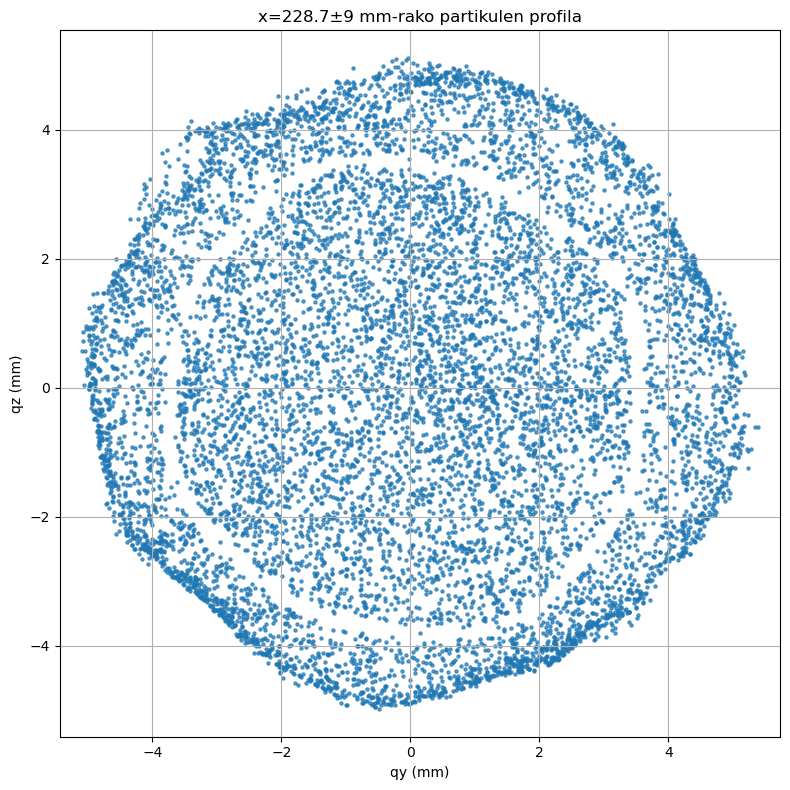

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(df_results['qy'], df_results['qz'], s=5, alpha=0.7)

plt.title(f"x={target_x}±{tolerance} mm-rako partikulen profila")
plt.xlabel("qy (mm)")
plt.ylabel("qz (mm)")
plt.grid(True)
plt.axis('equal') 

plt.tight_layout()
plt.show()

In [46]:
y_emittance = emittance_rms(df_results['qy'], df_results['py'])
z_emittance = emittance_rms(df_results['qz'], df_results['pz'])

print("Emitantzia-y:", y_emittance, " (mm rad)")
print("Emitantzia-z:", z_emittance, " (mm rad)")

Emitantzia-y: 0.0024665431839476274  (mm rad)
Emitantzia-z: 0.0026531686748946974  (mm rad)


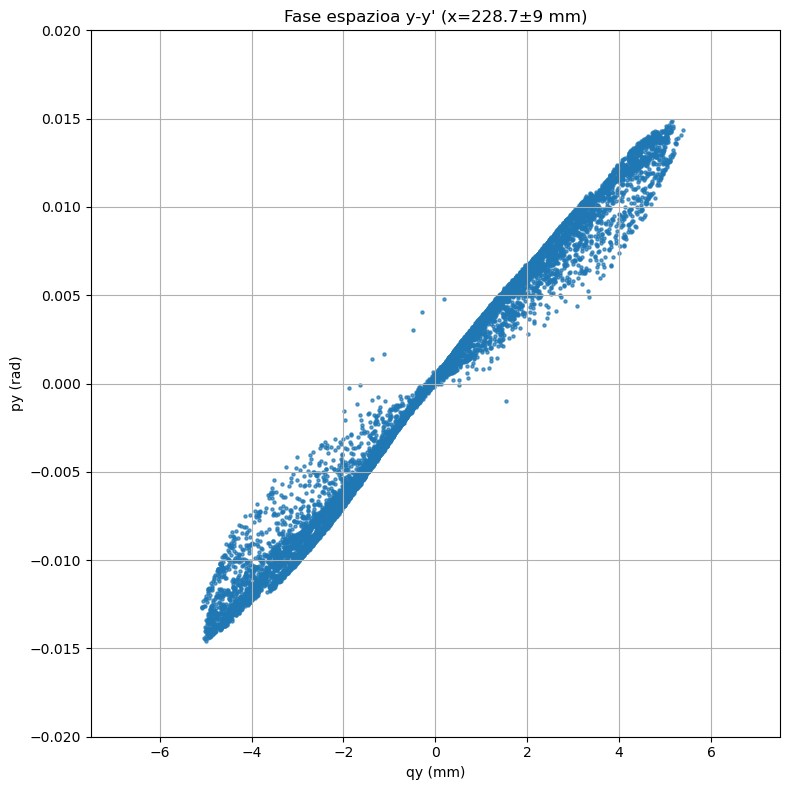

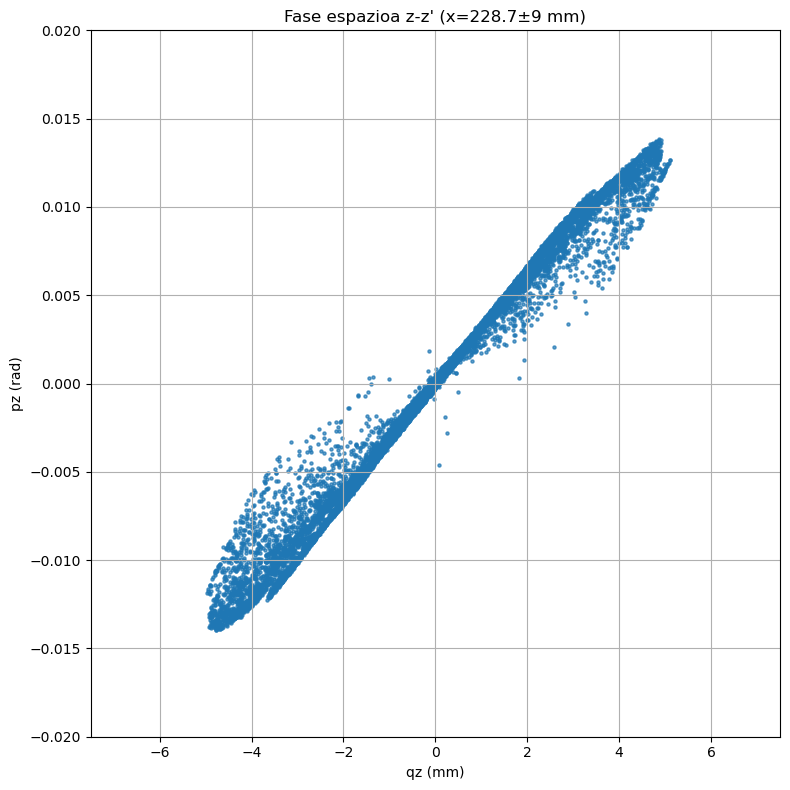

In [47]:
plt.figure(figsize=(8, 8))
plt.scatter(df_results['qy'], df_results['py'], s=5, alpha=0.7)

plt.title(f"Fase espazioa y-y' (x={target_x}±{tolerance} mm)")
plt.xlabel("qy (mm)")
plt.ylabel("py (rad)")
plt.grid(True)
plt.xlim(-7.5,7.5)
plt.ylim(-0.02,0.02)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(df_results['qz'], df_results['pz'], s=5, alpha=0.7)

plt.title(f"Fase espazioa z-z' (x={target_x}±{tolerance} mm)")
plt.xlabel("qz (mm)")
plt.ylabel("pz (rad)")
plt.grid(True)
plt.xlim(-7.5,7.5)
plt.ylim(-0.02,0.02)

plt.tight_layout()
plt.show()

## PROFILAK ETA FASE-ESPAZIOAK IRUDIKATU, EMITANTZIAK LORTU (partikuletan banatuta)

In [48]:
df_proton = df_results[np.isclose(df_results["mp"], 1.67262190E-27, atol=1e-30)]
df_dihydrogen = df_results[np.isclose(df_results["mp"], 3.34524380E-27, atol=1e-30)]
df_trihydrogen = df_results[np.isclose(df_results["mp"], 5.01786569E-27, atol=1e-30)]

In [49]:
y_emittance = emittance_rms(df_proton['qy'], df_proton['py'])
z_emittance = emittance_rms(df_proton['qz'], df_proton['pz'])

print("Protoien emitantzia-y:", y_emittance, " (mm rad)")
print("Protoien emitantzia-z:", z_emittance, " (mm rad)")

Protoien emitantzia-y: 0.0024665431839476274  (mm rad)
Protoien emitantzia-z: 0.0026531686748946974  (mm rad)


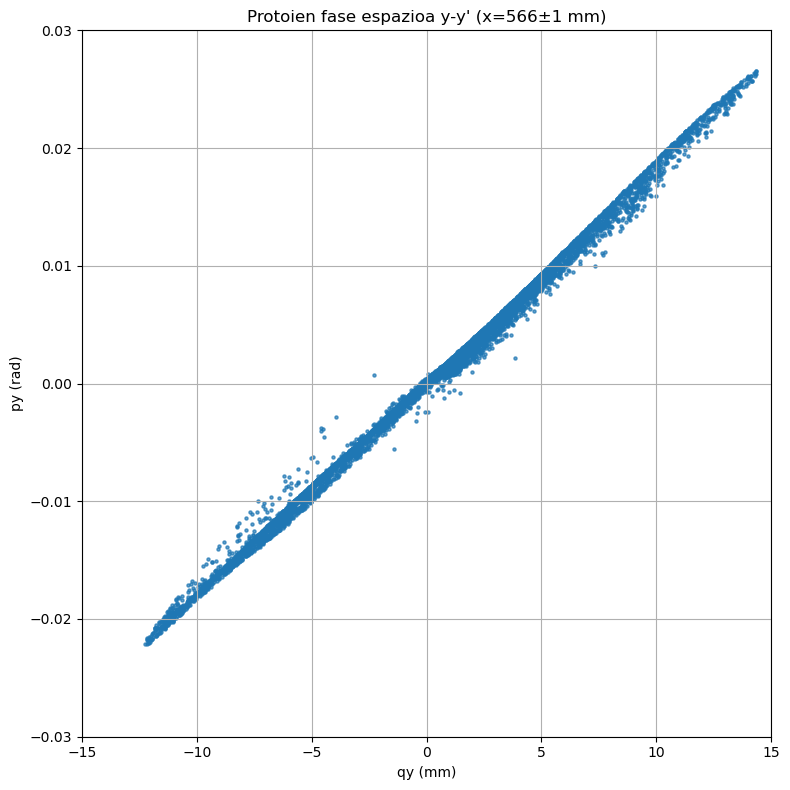

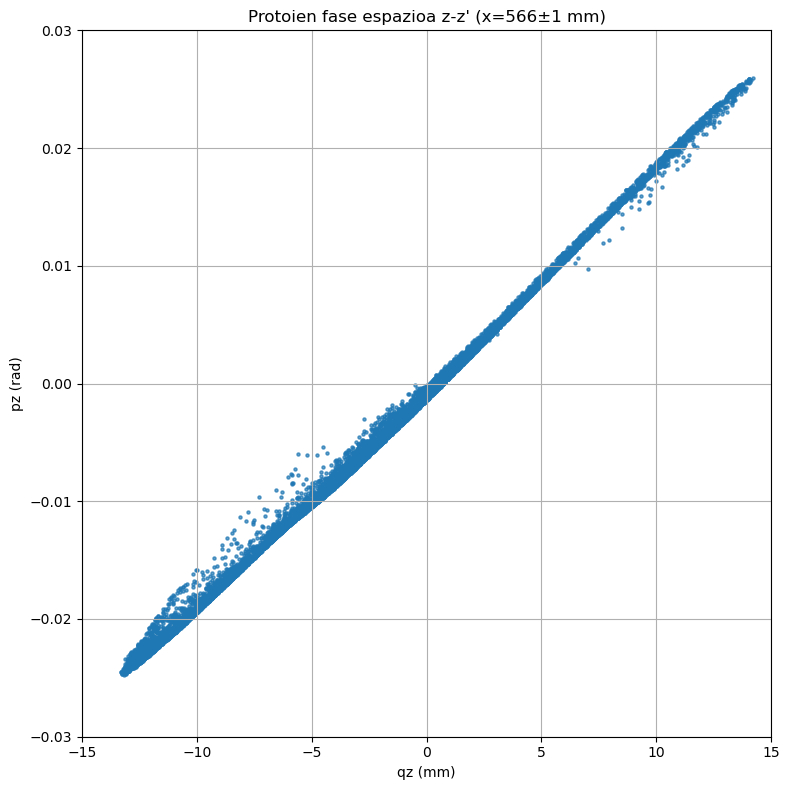

In [15]:
plt.figure(figsize=(8, 8))
plt.scatter(df_proton['qy'], df_proton['py'], s=5, alpha=0.7)

plt.title(f"Protoien fase espazioa y-y' (x={target_x}±{tolerance} mm)")
plt.xlabel("qy (mm)")
plt.ylabel("py (rad)")
plt.grid(True)
plt.xlim(-15,15)
plt.ylim(-0.03,0.03)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(df_proton['qz'], df_proton['pz'], s=5, alpha=0.7)

plt.title(f"Protoien fase espazioa z-z' (x={target_x}±{tolerance} mm)")
plt.xlabel("qz (mm)")
plt.ylabel("pz (rad)")
plt.grid(True)
plt.xlim(-15,15)
plt.ylim(-0.03,0.03)

plt.tight_layout()
plt.show()

In [16]:
y_emittance = emittance_rms(df_dihydrogen['qy'], df_dihydrogen['py'])
z_emittance = emittance_rms(df_dihydrogen['qz'], df_dihydrogen['pz'])

print("Dihidrogenoaren emitantzia-y:", y_emittance, " (mm rad)")
print("Dihidrogenoaren emitantzia-z:", z_emittance, " (mm rad)")

Dihidrogenoaren emitantzia-y: nan  (mm rad)
Dihidrogenoaren emitantzia-z: nan  (mm rad)


C:\Users\lopez\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lopez\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


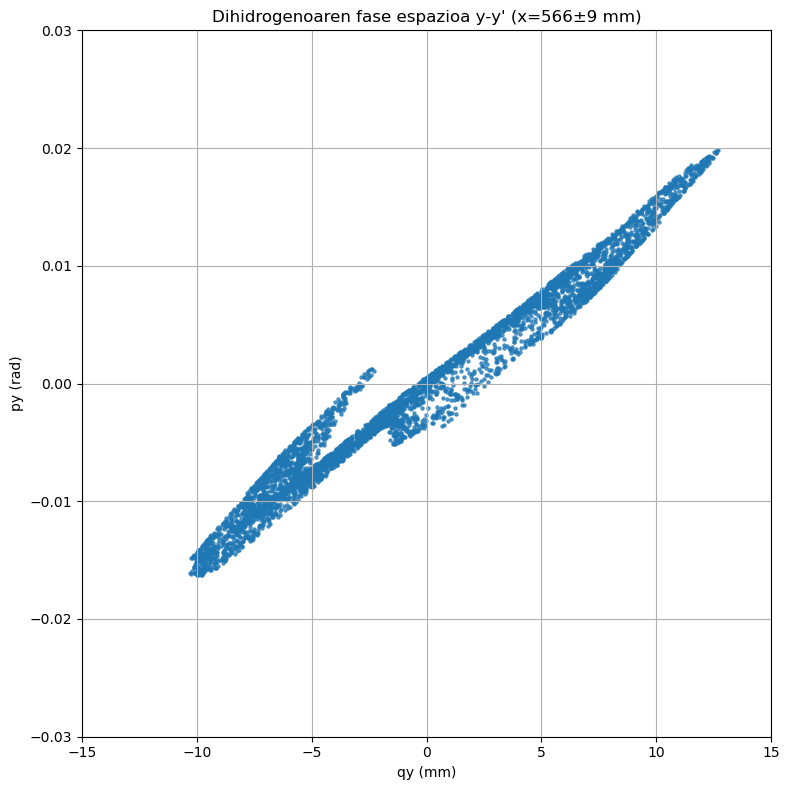

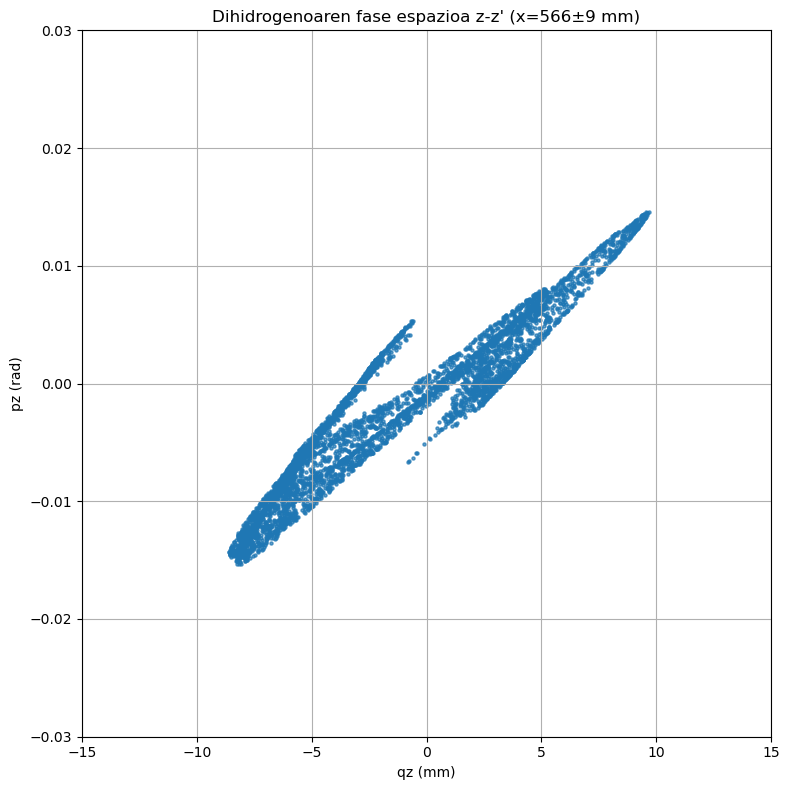

In [169]:
plt.figure(figsize=(8, 8))
plt.scatter(df_dihydrogen['qy'], df_dihydrogen['py'], s=5, alpha=0.7)

plt.title(f"Dihidrogenoaren fase espazioa y-y' (x={target_x}±{tolerance} mm)")
plt.xlabel("qy (mm)")
plt.ylabel("py (rad)")
plt.grid(True)
plt.xlim(-15,15)
plt.ylim(-0.03,0.03)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(df_dihydrogen['qz'], df_dihydrogen['pz'], s=5, alpha=0.7)

plt.title(f"Dihidrogenoaren fase espazioa z-z' (x={target_x}±{tolerance} mm)")
plt.xlabel("qz (mm)")
plt.ylabel("pz (rad)")
plt.grid(True)
plt.xlim(-15,15)
plt.ylim(-0.03,0.03)

plt.tight_layout()
plt.show()

In [170]:
y_emittance = emittance_rms(df_trihydrogen['qy'], df_trihydrogen['py'])
z_emittance = emittance_rms(df_trihydrogen['qz'], df_trihydrogen['pz'])

print("Trihidrogenoaren emitantzia-y:", y_emittance, " (mm rad)")
print("Trihidrogenoaren emitantzia-z:", z_emittance, " (mm rad)")

Trihidrogenoaren emitantzia-y: 0.010067988052497638  (mm rad)
Trihidrogenoaren emitantzia-z: 0.012103239176877957  (mm rad)


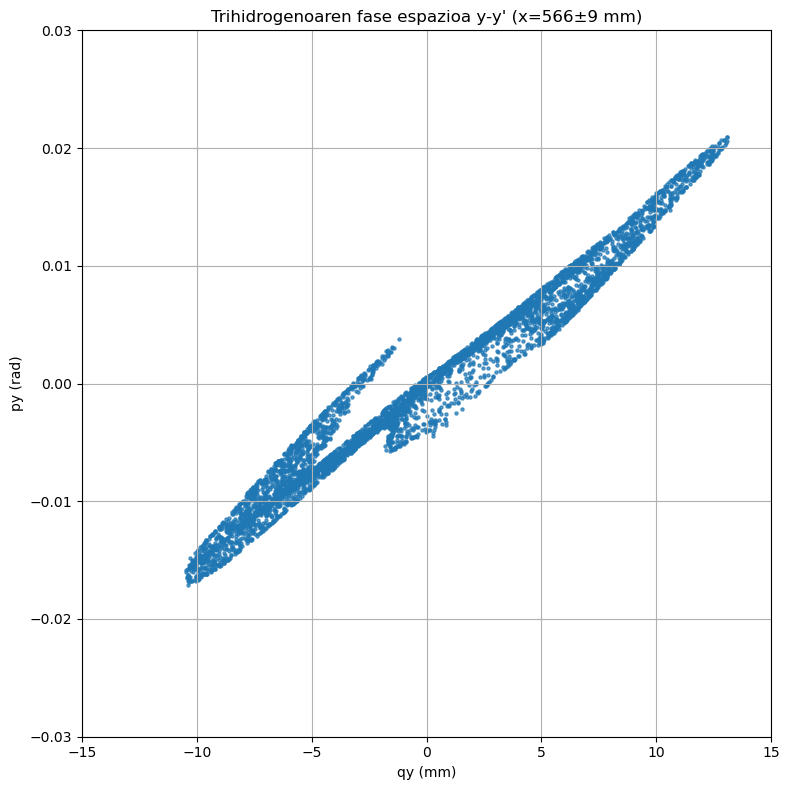

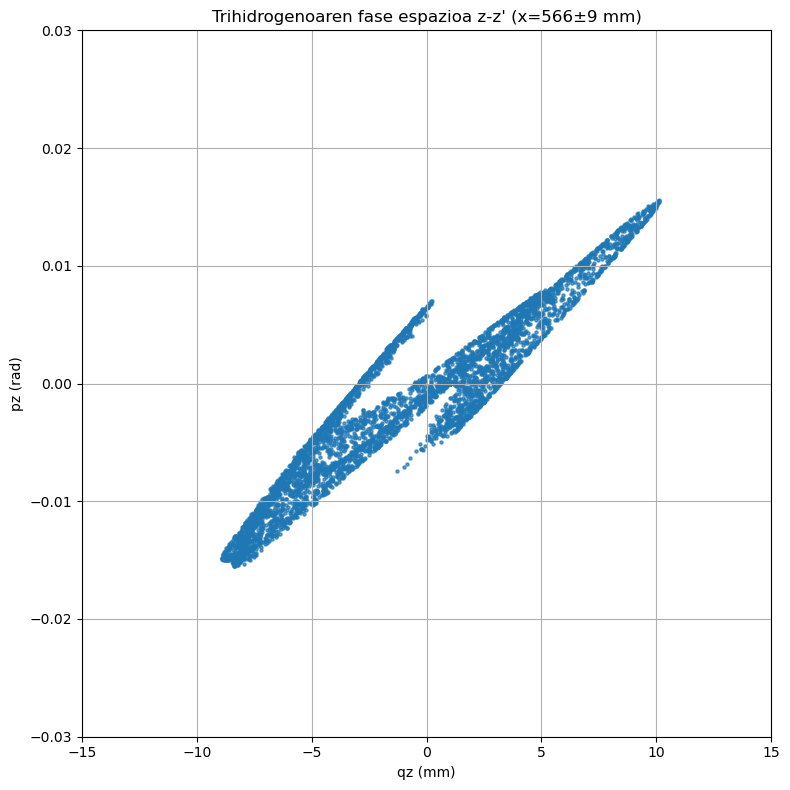

In [171]:
plt.figure(figsize=(8, 8))
plt.scatter(df_trihydrogen['qy'], df_trihydrogen['py'], s=5, alpha=0.7)

plt.title(f"Trihidrogenoaren fase espazioa y-y' (x={target_x}±{tolerance} mm)")
plt.xlabel("qy (mm)")
plt.ylabel("py (rad)")
plt.grid(True)
plt.xlim(-15,15)
plt.ylim(-0.03,0.03)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(df_trihydrogen['qz'], df_trihydrogen['pz'], s=5, alpha=0.7)

plt.title(f"Trihidrogenoaren fase espazioa z-z' (x={target_x}±{tolerance} mm)")
plt.xlabel("qz (mm)")
plt.ylabel("pz (rad)")
plt.grid(True)
plt.xlim(-15,15)
plt.ylim(-0.03,0.03)

plt.tight_layout()
plt.show()